In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive/', force_remount=True)
sys.path.append("/content/drive/My Drive/OptimizerResearch/")

Mounted at /content/drive/


In [ ]:
import pytest
import numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from autograd.misc.optimizers import adam
from Optimizer_Scripts.functions import ackley_gen, rastrigin_gen, ackley_deriv_gen, rast_deriv_gen, poly, poly_1, poly_1_grad
from Optimizer_Scripts.optimizers import Adam, Momentum, NesterovMomentum
from Optimizer_Scripts.Delayer import Delayer
import Optimizer_Scripts.learning_rate_generator as lrg

In [ ]:
def test_adam_rast():
    #get the objective and gradient functions
    n_list = [2,5,10,100,150,200]
    objective_list = [rastrigin_gen(n) for n in n_list]
    grad_objective_list = [rast_deriv_gen(n) for n in n_list]
    params=dict()
    opt_params = dict()
    #set the relavant hyperparameters
    max_iter = 30
    learning_rate = 0.001
    opt_params['learning_rate'] = learning_rate
    params['learning_rate'] = lrg.const_lr_gen(opt_params)
    beta_1 = 0.72
    beta_2 = 0.84
    epsilon = 1e-5
    params['beta_1'] = beta_1
    params['beta_2'] = beta_2
    params['epsilon'] = epsilon
    for i in range(len(objective_list)):
        objective = objective_list[i]
        n = n_list[i]
        grad_objective = grad_objective_list[i]
        for j in range(100):
            if (j == 0):
                x_init = np.zeros(n,dtype=float)
            elif (j == 97):
                x_init = 5.12 * np.ones(n)
                x_init[:len(x_init):2] = -5.12
            elif (j == 98):
                x_init = 5.12 * np.ones(n)
            elif (j == 99):
                x_init = -5.12 * np.ones(n)
            else:
                x_init = np.random.uniform(-5.12,5.12,n)
            #use the autograd adam optimizers
            state_test = adam(grad=grad_objective, x0=x_init, num_iters=max_iter, step_size = learning_rate, b1=beta_1, b2 = beta_2, eps = epsilon)
            val_test = objective(state_test)
            #now use my optimizer
            adam_optimizer = Adam(params=params, epsilon=epsilon)
            my_opt = Delayer(n=n, x_init=x_init, optimizer=adam_optimizer, loss_function=objective, grad=grad_objective)  
            my_opt.compute_time_series(use_delays=False,maxiter=max_iter)
            state_mine = my_opt.final_state
            final_val = my_opt.final_val
            assert np.allclose(state_test, state_mine), "Adam rastrigin fail on initial value {} with {} dimensions".format(x_init,n)
            assert np.allclose(final_val, val_test), "Adam rastrigin fail on final evaluation computation"
            del my_opt
            del state_test

def test_adam_ack():
    #get the objective and gradient functions
    n_list = [2,5,10,100,150,200]
    objective_list = [ackley_gen(n) for n in n_list]
    grad_objective_list = [ackley_deriv_gen(n) for n in n_list]
    params=dict()
    opt_params = dict()
    #set the relavant hyperparameters
    max_iter = 11
    learning_rate = 0.001
    opt_params['learning_rate'] = learning_rate
    params['learning_rate'] = lrg.const_lr_gen(opt_params)
    beta_1 = 0.72
    beta_2 = 0.84
    epsilon = 1e-5
    params['beta_1'] = beta_1
    params['beta_2'] = beta_2
    params['epsilon'] = epsilon
    for i in range(len(objective_list)):
        objective = objective_list[i]
        n = n_list[i]
        grad_objective = grad_objective_list[i]
        for j in range(100):
            if (j == 0):
                x_init = 1e-18*np.ones(n,dtype=float)
            elif (j == 97):
                x_init = 32. * np.ones(n)
                x_init[:len(x_init):2] = -32.
            elif (j == 98):
                x_init = 32. * np.ones(n)
            elif (j == 99):
                x_init = -32 * np.ones(n)
            else:
                x_init = np.random.uniform(-32.,32.,n)
            #use the autograd adam optimizers
            state_test = adam(grad=grad_objective, x0=x_init, num_iters=max_iter, step_size = learning_rate, b1=beta_1, b2 = beta_2, eps = epsilon)
            val_test = objective(state_test)
            #now use my optimizer
            adam_optimizer = Adam(params=params, epsilon=epsilon)
            my_opt = Delayer(n=n, x_init=x_init, optimizer=adam_optimizer, loss_function=objective, grad=grad_objective)  
            my_opt.compute_time_series(use_delays=False,maxiter=max_iter)
            state_mine = my_opt.final_state
            final_val = my_opt.final_val
            assert np.allclose(state_test, state_mine), "Adam ackley fail on initial value {} with {} dimensions".format(x_init,n)
            assert np.allclose(final_val, val_test), "Adam ackley fail on final evaluation computation"
            del my_opt
            del state_test

In [ ]:
test_adam_rast()
test_adam_ack()

Plot the different learning rate functions

In [ ]:
#constant learning rates
def generate_rates(opt_params_undel, opt_params_del, constant=True, num_gen=2000, loss_name = "Ackley 2d"):
    learning_rate_undel = lrg.generate_learning_rates(constant, opt_params_undel)
    learning_rate_del = lrg.generate_learning_rates(constant, opt_params_del)
    learning_rates_undel = list()
    learning_rates_del = list()
    for i in range(num_gen):
        learning_rates_undel.append(next(learning_rate_undel))
        learning_rates_del.append(next(learning_rate_del))
    plt.plot(learning_rates_undel, label="Undelayed") 
    plt.plot(learning_rates_del,label="Delayed")
    plt.title("Learning Rates for {}".format(loss_name))
    plt.legend()
    plt.show()

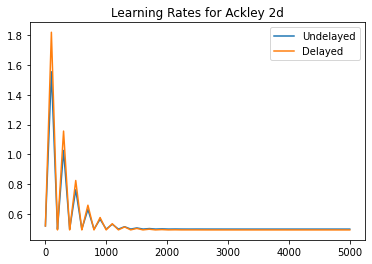

In [ ]:
opt_params_undel = dict()
opt_params_undel['min_learning_rate'] = 0.5192
opt_params_undel['max_learning_rate'] = 1.575
opt_params_undel['step_size']	= 100
opt_params_del = dict()
opt_params_del['min_learning_rate'] = 0.5192
opt_params_del['max_learning_rate'] = 1.8457
opt_params_del['step_size']	= 100
generate_rates(opt_params_undel, opt_params_del, constant=False, num_gen = 5000, loss_name = "Ackley 2d")

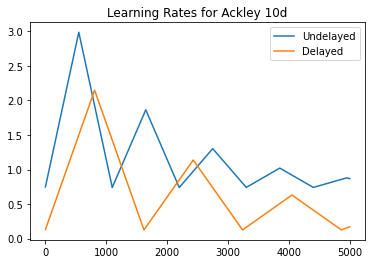

In [ ]:
opt_params_undel = dict()
opt_params_undel['min_learning_rate'] = 0.7487
opt_params_undel['max_learning_rate'] = 2.996
opt_params_undel['step_size']	= 550
opt_params_del = dict()
opt_params_del['min_learning_rate'] = 0.1309
opt_params_del['max_learning_rate'] = 2.1543
opt_params_del['step_size']	= 810
generate_rates(opt_params_undel, opt_params_del, constant=False, num_gen = 5000, loss_name = "Ackley 10d")

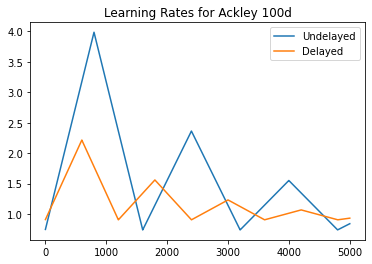

In [ ]:
opt_params_undel = dict()
opt_params_undel['min_learning_rate'] = 0.7477
opt_params_undel['max_learning_rate'] = 3.9956
opt_params_undel['step_size']	= 800
opt_params_del = dict()
opt_params_del['min_learning_rate'] = 0.9096
opt_params_del['max_learning_rate'] = 2.2202
opt_params_del['step_size']	= 600
generate_rates(opt_params_undel, opt_params_del, constant=False, num_gen = 5000, loss_name = "Ackley 100d")

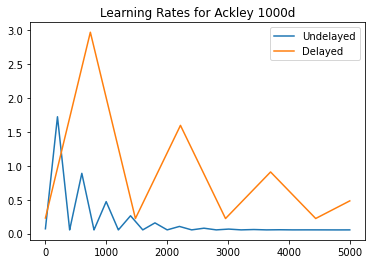

In [ ]:
opt_params_undel = dict()
opt_params_undel['min_learning_rate'] = 0.0702
opt_params_undel['max_learning_rate'] = 1.7406
opt_params_undel['step_size']	= 200
opt_params_del = dict()
opt_params_del['min_learning_rate'] = 0.229
opt_params_del['max_learning_rate'] = 2.9789
opt_params_del['step_size']	= 740
generate_rates(opt_params_undel, opt_params_del, constant=False, num_gen = 5000, loss_name = "Ackley 1000d")

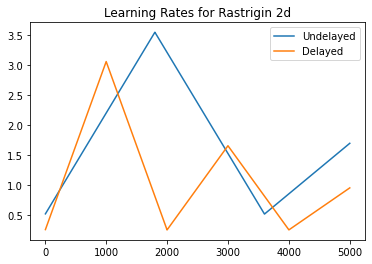

In [ ]:
opt_params_undel = dict()
opt_params_undel['min_learning_rate'] = 0.5271
opt_params_undel['max_learning_rate'] = 3.557
opt_params_undel['step_size']	= 1800
opt_params_del = dict()
opt_params_del['min_learning_rate'] = 0.2651
opt_params_del['max_learning_rate'] = 3.0705
opt_params_del['step_size']	= 1000
generate_rates(opt_params_undel, opt_params_del, constant=False, num_gen = 5000, loss_name = "Rastrigin 2d")

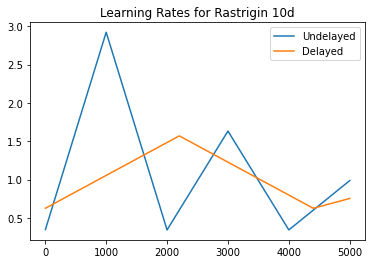

In [ ]:
opt_params_undel = dict()
opt_params_undel['min_learning_rate'] = 0.3478
opt_params_undel['max_learning_rate'] = 2.9283
opt_params_undel['step_size']	= 1000
opt_params_del = dict()
opt_params_del['min_learning_rate'] = 0.6253
opt_params_del['max_learning_rate'] = 1.5716
opt_params_del['step_size']	= 2200
generate_rates(opt_params_undel, opt_params_del, constant=False, num_gen = 5000, loss_name = "Rastrigin 10d")

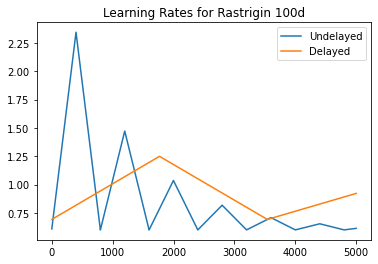

In [ ]:
opt_params_undel = dict()
opt_params_undel['min_learning_rate'] = 0.608
opt_params_undel['max_learning_rate'] = 2.3532
opt_params_undel['step_size']	= 400
opt_params_del = dict()
opt_params_del['min_learning_rate'] = 0.692
opt_params_del['max_learning_rate'] = 1.2499
opt_params_del['step_size']	= 1770
generate_rates(opt_params_undel, opt_params_del, constant=False, num_gen = 5000, loss_name = "Rastrigin 100d")

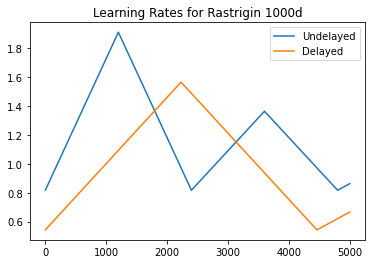

In [ ]:
opt_params_undel = dict()
opt_params_undel['min_learning_rate'] = 0.8184
opt_params_undel['max_learning_rate'] = 1.9099
opt_params_undel['step_size']	= 1200
opt_params_del = dict()
opt_params_del['min_learning_rate'] = 0.5436
opt_params_del['max_learning_rate'] = 1.5646
opt_params_del['step_size']	= 2230
generate_rates(opt_params_undel, opt_params_del, constant=False, num_gen = 5000, loss_name = "Rastrigin 1000d")

In [ ]:
def compute_full(partial=0.1, beta_1=0.9, beta_2=0.999, iter_num=100):
    return partial * np.sqrt(1-beta_2**iter_num)/(1-beta_1**iter_num)

def adam_total_learning_rates(iters=5000, beta_1=0.9, beta_2=0.999, constant=False,
                              opt_params_undel=None, opt_params_del=None, 
                              loss_name = "Ackley 2d"):
    learning_rate_undel = lrg.generate_learning_rates(constant, opt_params_undel)
    learning_rate_del = lrg.generate_learning_rates(constant, opt_params_del)
    learning_rates_undel = list()
    learning_rates_del = list()
    for i in range(iters):
        learning_rates_undel.append(compute_full(partial=next(learning_rate_undel), beta_1=beta_1, beta_2=beta_2, iter_num=i))
        learning_rates_del.append(compute_full(partial=next(learning_rate_del), beta_1=beta_1, beta_2=beta_2, iter_num=i))
    plt.plot(learning_rates_undel, label="Undelayed") 
    plt.plot(learning_rates_del,label="Delayed")
    plt.title("Learning Rates for {}".format(loss_name))
    plt.legend()
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


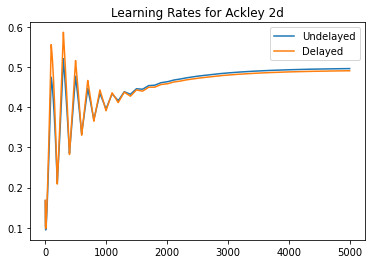

In [ ]:
opt_params_undel = dict()
opt_params_undel['min_learning_rate'] = 0.5192
opt_params_undel['max_learning_rate'] = 1.575
opt_params_undel['step_size']	= 100
opt_params_del = dict()
opt_params_del['min_learning_rate'] = 0.5192
opt_params_del['max_learning_rate'] = 1.8457
opt_params_del['step_size']	= 100
adam_total_learning_rates(opt_params_undel=opt_params_undel, opt_params_del=opt_params_del, constant=False, iters = 5000, loss_name = "Ackley 2d")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


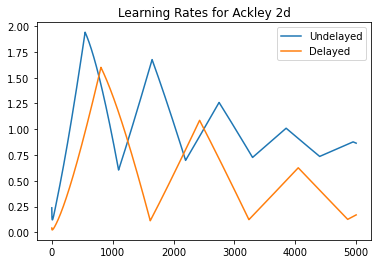

In [ ]:
opt_params_undel = dict()
opt_params_undel['min_learning_rate'] = 0.7487
opt_params_undel['max_learning_rate'] = 2.996
opt_params_undel['step_size']	= 550
opt_params_del = dict()
opt_params_del['min_learning_rate'] = 0.1309
opt_params_del['max_learning_rate'] = 2.1543
opt_params_del['step_size']	= 810
adam_total_learning_rates(opt_params_undel=opt_params_undel, opt_params_del=opt_params_del, constant=False, iters = 5000, loss_name = "Ackley 10d")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


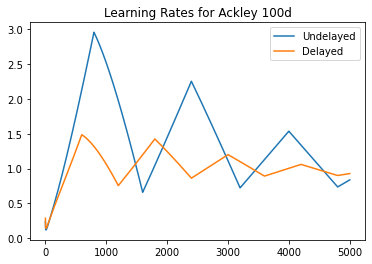

In [ ]:
opt_params_undel = dict()
opt_params_undel['min_learning_rate'] = 0.7477
opt_params_undel['max_learning_rate'] = 3.9956
opt_params_undel['step_size']	= 800
opt_params_del = dict()
opt_params_del['min_learning_rate'] = 0.9096
opt_params_del['max_learning_rate'] = 2.2202
opt_params_del['step_size']	= 600
adam_total_learning_rates(opt_params_undel=opt_params_undel, opt_params_del=opt_params_del, constant=False, iters = 5000, loss_name = "Ackley 100d")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


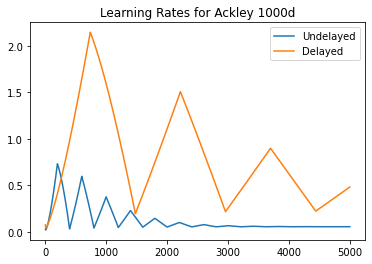

In [ ]:
opt_params_undel = dict()
opt_params_undel['min_learning_rate'] = 0.0702
opt_params_undel['max_learning_rate'] = 1.7406
opt_params_undel['step_size']	= 200
opt_params_del = dict()
opt_params_del['min_learning_rate'] = 0.229
opt_params_del['max_learning_rate'] = 2.9789
opt_params_del['step_size']	= 740
adam_total_learning_rates(opt_params_undel=opt_params_undel, opt_params_del=opt_params_del, constant=False, iters = 5000, loss_name = "Ackley 1000d")